## Imports

In [1]:
from torchvision.datasets import DatasetFolder, ImageFolder
from torchvision.transforms import v2
from torch.utils.data import DataLoader, Subset, ConcatDataset
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torch

import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split

from collections import Counter
from pathlib import Path
import time
import subprocess
import shutil
import json

## Data Preprocessing

In [2]:
# Kaggle Loaded Dataset Path (readonly)
root_input = Path("/kaggle/input/imagenet100")

# Working Dataset Path to modify the default
root_working = Path("/kaggle/working/reduced_imagenet")
root_working.mkdir(exist_ok=True)

if root_working.exists():
    print("The working directory was created successfully.")
else:
    print("There seems to be an issue.")

The working directory was created successfully.


In [3]:
# Loading all the labels
labels_path = Path(root_input / "Labels.json")

# Reading the Raw JSON Labels
labels = json.loads(labels_path.read_text())
print(json.dumps(labels, indent=4))

{
    "n01968897": "chambered nautilus, pearly nautilus, nautilus",
    "n01770081": "harvestman, daddy longlegs, Phalangium opilio",
    "n01818515": "macaw",
    "n02011460": "bittern",
    "n01496331": "electric ray, crampfish, numbfish, torpedo",
    "n01847000": "drake",
    "n01687978": "agama",
    "n01740131": "night snake, Hypsiglena torquata",
    "n01537544": "indigo bunting, indigo finch, indigo bird, Passerina cyanea",
    "n01491361": "tiger shark, Galeocerdo cuvieri",
    "n02007558": "flamingo",
    "n01735189": "garter snake, grass snake",
    "n01630670": "common newt, Triturus vulgaris",
    "n01440764": "tench, Tinca tinca",
    "n01819313": "sulphur-crested cockatoo, Kakatoe galerita, Cacatua galerita",
    "n02002556": "white stork, Ciconia ciconia",
    "n01667778": "terrapin",
    "n01755581": "diamondback, diamondback rattlesnake, Crotalus adamanteus",
    "n01924916": "flatworm, platyhelminth",
    "n01751748": "sea snake",
    "n01984695": "spiny lobster, lan

In [4]:
# Modifying the labels to retain only the first name
for index, item in enumerate(labels.items()):
    key, value = item
    class_name = value.split(",")[0]
    labels[key] = class_name

# Modified Labels
mod_labels = json.dumps(labels, indent=4)
print("All Labels:\n", mod_labels)

# Saving the Reduced Labels
with open(root_working / "labels.json", "w") as file:
    json.dump(labels, fp=file, indent=4)

All Labels:
 {
    "n01968897": "chambered nautilus",
    "n01770081": "harvestman",
    "n01818515": "macaw",
    "n02011460": "bittern",
    "n01496331": "electric ray",
    "n01847000": "drake",
    "n01687978": "agama",
    "n01740131": "night snake",
    "n01537544": "indigo bunting",
    "n01491361": "tiger shark",
    "n02007558": "flamingo",
    "n01735189": "garter snake",
    "n01630670": "common newt",
    "n01440764": "tench",
    "n01819313": "sulphur-crested cockatoo",
    "n02002556": "white stork",
    "n01667778": "terrapin",
    "n01755581": "diamondback",
    "n01924916": "flatworm",
    "n01751748": "sea snake",
    "n01984695": "spiny lobster",
    "n01729977": "green snake",
    "n01614925": "bald eagle",
    "n01608432": "kite",
    "n01443537": "goldfish",
    "n01770393": "scorpion",
    "n01855672": "goose",
    "n01560419": "bulbul",
    "n01592084": "chickadee",
    "n01914609": "sea anemone",
    "n01582220": "magpie",
    "n01667114": "mud turtle",
    "n0

In [5]:
print("The copying process has started")

# Iterating over the directories at root
for parent_node in root_input.iterdir():

    # Avoiding the Label File
    if not parent_node.is_dir():
        continue

    # Retrieving the Split Name
    split_name = parent_node.stem.split(".")[0]

    # Executing the Copy based on the Split Name
    if split_name == "train" :
        dest_path = root_working / "train"
    elif split_name == "val":
        dest_path = root_working / "valid"
        
    # Creating the directory
    dest_path.mkdir(exist_ok=True)
    
    # Iterating through the classes on sub-nodes
    for sub_node in parent_node.iterdir():

        # If Class ID in Reduced => Backtrack the name and copy
        if sub_node.stem in labels.keys():
            class_name = labels[sub_node.stem]
            completed_path = dest_path / class_name
            shutil.copytree(sub_node, completed_path, dirs_exist_ok=True)

print("Copy Process Completed")

The copying process has started
Copy Process Completed


## Data Handling

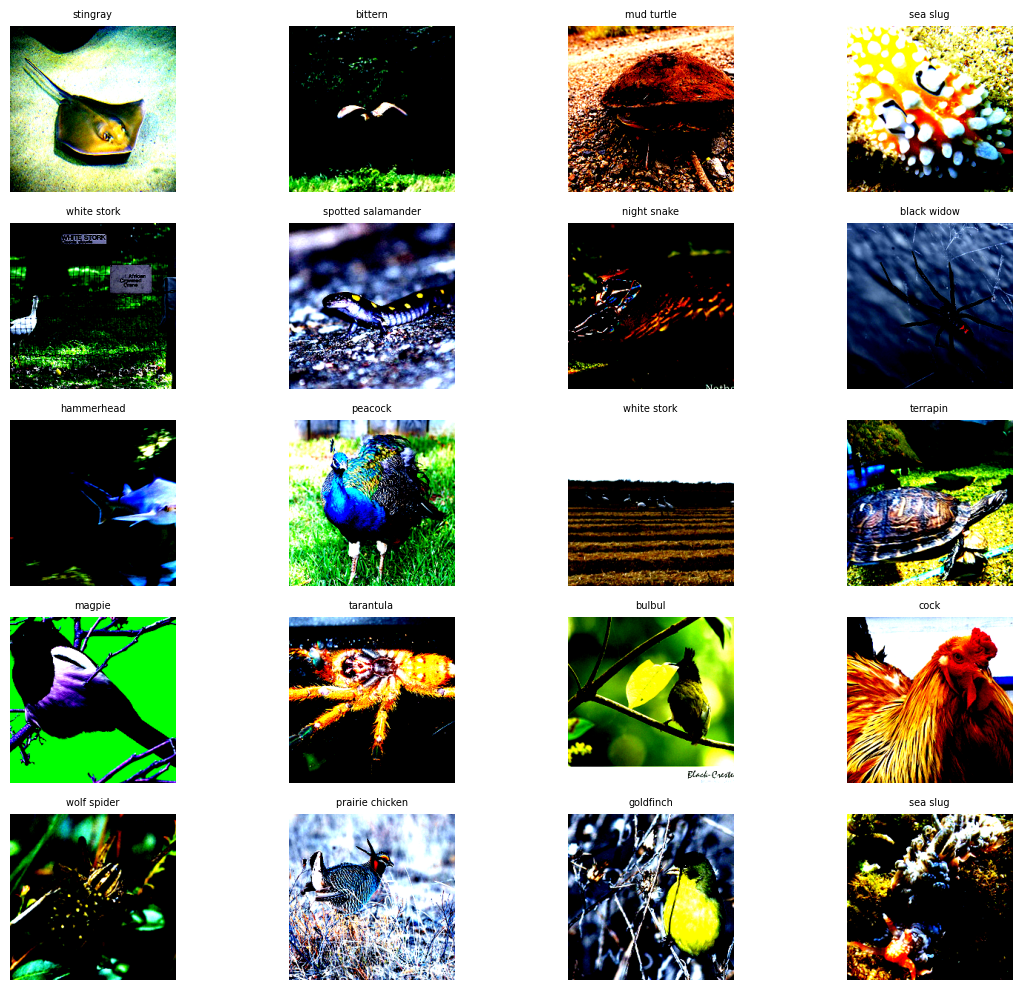

In [6]:
# Dataset Working Path
dataset_path = Path("/kaggle/working/reduced_imagenet")


class DataHandler:
    """This class is responsible for loading the datasets."""
    def __init__(self, root_dir: Path) -> None:
        self.root_dir = root_dir
        self.norm_means = [0.485, 0.456, 0.406]
        self.norm_stds = [0.229, 0.224, 0.225]

        self.apply_transforms = v2.Compose([
            v2.Resize(size=256, interpolation=v2.InterpolationMode.BICUBIC),  # Maintaining the Aspect Ratio
            v2.CenterCrop(size=(224, 224)),  # Crop the Image to the Subject
            v2.ToImage(),  # Converts PIL Image to Tensor
            v2.ToDtype(torch.float32, scale=True),  # Converting the Dtype for Normalisation
            v2.Normalize(mean=self.norm_means, std=self.norm_stds),  # Applies Normalisation
        ])

    def load_set(self, set_name: str) -> DatasetFolder:
        """Loads the set by the specified set_name."""

        if set_name == "train":
            dataset_path = self.root_dir / "train"
        elif set_name == "valid":
            dataset_path = self.root_dir / "valid"
        else:
            raise UnboundLocalError("Invalid set name provided.")

        dataset = ImageFolder(root=dataset_path, transform=self.apply_transforms)
        self.class_names = dataset.classes
        return dataset

    def move_samples_from_train(
        self, train_set: DatasetFolder, 
        move_percent: float = 0.12
    ) -> tuple[Subset, Subset]:
        """Moves a fixed number of samples from train to valid for better split."""

        targets = np.array(train_set.targets)
        indices = range(len(train_set))
        
        # Stratified Sampling of the Train Set
        train_indices, valid_indices = train_test_split(
            indices, test_size=move_percent, stratify=targets
        )
        
        # Subsets
        train_set_pre_prep = Subset(train_set, train_indices)
        valid_set_pre_prep = Subset(train_set, valid_indices)

        return train_set_pre_prep, valid_set_pre_prep
    
    def prepare_dataset(self, dataset: DatasetFolder, batch_size: int=64, shuffle: bool=True) -> DataLoader:
        """Returns the prepared and loaded dataset."""

        return DataLoader(
            dataset=dataset, 
            batch_size=batch_size,
            shuffle=shuffle,
            num_workers=4
        )
    
    def view_images(self, loaded_set: DataLoader) -> None:
        """Helper function just to view the images."""
        images, targets = next(iter(loaded_set))

        plt.figure(figsize=(12, 10))
        for i in range(20):
            img = images[i].squeeze()
            label = targets[i]

            plt.subplot(5, 4, i + 1)
            plt.title(f"{self.class_names[label]}", fontdict={"size": 7})
            plt.imshow(img.permute(1, 2, 0))
            plt.axis("off")
        
        plt.tight_layout()
        plt.show()


# Testing
data_handle = DataHandler(root_dir=dataset_path)
train_loaded = data_handle.load_set("train")
train_prep = data_handle.prepare_dataset(dataset=train_loaded)
class_names = data_handle.class_names
data_handle.view_images(loaded_set=train_prep)

**Important**
- The images are a little weird as the norm is turned on should be fine with it off just for visualisation purposes.

In [7]:
# Class Names as in the dataset
print("Total No of Classes: ", len(class_names))
print("\nClass Names:\n", class_names)

Total No of Classes:  100

Class Names:
 ['American alligator', 'American coot', 'Dungeness crab', 'Komodo dragon', 'agama', 'albatross', 'axolotl', 'bald eagle', 'banded gecko', 'barn spider', 'bee eater', 'bittern', 'black and gold garden spider', 'black grouse', 'black swan', 'black widow', 'boa constrictor', 'bulbul', 'bustard', 'chambered nautilus', 'chickadee', 'chiton', 'cock', 'common iguana', 'common newt', 'conch', 'coucal', 'crane', 'crayfish', 'diamondback', 'drake', 'electric ray', 'flamingo', 'flatworm', 'garden spider', 'garter snake', 'goldfinch', 'goldfish', 'goose', 'great grey owl', 'great white shark', 'green lizard', 'green mamba', 'green snake', 'hammerhead', 'harvestman', 'hen', 'hermit crab', 'hognose snake', 'hornbill', 'horned viper', 'hummingbird', 'indigo bunting', 'jellyfish', 'king snake', 'kite', 'leatherback turtle', 'limpkin', 'loggerhead', 'lorikeet', 'macaw', 'magpie', 'mud turtle', 'nematode', 'night snake', 'oystercatcher', 'peacock', 'pelican', 'pr

## The Residual Block

In [8]:
class ResidualBlock34(torch.nn.Module):
    """This class implements the Residual Learning block for Resnet34."""

    def __init__(self, in_channels: int, out_channels: int, stride: int) -> None:

        # Loading all the parameters and properties from the parent class.
        super().__init__()

        self.sequential_conv_block = torch.nn.Sequential(
            torch.nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=3, padding=1, stride=stride),
            torch.nn.GroupNorm(num_groups=1, num_channels=out_channels),
            torch.nn.ReLU(),
            torch.nn.Conv2d(in_channels=out_channels, out_channels=out_channels, kernel_size=3, padding=1),
            torch.nn.GroupNorm(num_groups=1, num_channels=out_channels),
        )

        if stride > 1 or in_channels != out_channels:
            self.skip_layer = torch.nn.Sequential(
                torch.nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=1, stride=stride),
                torch.nn.GroupNorm(num_groups=1, num_channels=out_channels)
            )
        else:
            self.skip_layer = torch.nn.Identity()
        
    def forward(self, X: torch.Tensor) -> torch.Tensor:
        """Implementation of the forward propagation of the residual learning block."""

        # Conv Layer Prop
        conv_logits = self.sequential_conv_block(X)

        # Skip Layer Prop
        skip_logits = self.skip_layer(X)

        # Concatenating the logits
        logits = conv_logits + skip_logits

        # Activating the logits
        activated_logits = torch.nn.ReLU()(logits)

        return activated_logits


# Testing
first_residual_block = ResidualBlock34(256, 2, 512)
print(first_residual_block)

ResidualBlock34(
  (sequential_conv_block): Sequential(
    (0): Conv2d(256, 2, kernel_size=(3, 3), stride=(512, 512), padding=(1, 1))
    (1): GroupNorm(1, 2, eps=1e-05, affine=True)
    (2): ReLU()
    (3): Conv2d(2, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): GroupNorm(1, 2, eps=1e-05, affine=True)
  )
  (skip_layer): Sequential(
    (0): Conv2d(256, 2, kernel_size=(1, 1), stride=(512, 512))
    (1): GroupNorm(1, 2, eps=1e-05, affine=True)
  )
)


## The Resnet-34 Model

In [9]:
class Resnet34(torch.nn.Module):
    """This class implements the Resnet-34 model."""

    initial_fmaps = 64
    initial_kernel_size = 7
    initial_stride = 2
    initial_pool_size = 3

    def __init__(self, in_channels: int = 3, fc_size: int = 1000, dropout_rate: float = 0.2):

        # Loading all the properties and parameters from the super class
        super().__init__()

        # Initial Layers of the Model conv1
        self.model_modules = torch.nn.Sequential(
            torch.nn.Conv2d(
                in_channels=in_channels,
                out_channels=self.initial_fmaps,
                kernel_size=self.initial_kernel_size,
                stride=self.initial_stride,
                padding=3
            ),
            torch.nn.GroupNorm(
                num_groups=1,
                num_channels=self.initial_fmaps
            ),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(
                kernel_size=self.initial_pool_size,
                stride=2,
                padding=1
            )
        )
        
        # Model Architecture Configurations
        model_config = [(64, 3), (128, 4), (256, 6), (512, 3)]
        prev_num_channels = model_config[0][0]

        # Constructing the rest of the layers
        for layer_idx, (num_channels, num_blocks) in enumerate(model_config):
            
            # Iterating over each of the block sequences
            for block in range(num_blocks):

                # Default stride
                stride = 1

                # If the first block of a sequence check for downsampling
                if block == 0:

                    # Avoiding downsampling for the first layer
                    stride = 2 if layer_idx != 0 else 1

                    # Appending the new block
                    self.model_modules.append(
                        ResidualBlock34(
                            in_channels=prev_num_channels,
                            out_channels=num_channels,
                            stride=stride
                        )
                    )
                # If block in the middle of the sequence default stride
                else:
                    self.model_modules.append(
                        ResidualBlock34(
                            in_channels=prev_num_channels,
                            out_channels=num_channels,
                            stride=stride
                        )
                    )

                # Updating the no of previous channels
                prev_num_channels = num_channels
            
            # Dropout Regularization after each block
            self.model_modules.append(
                torch.nn.Dropout(p=dropout_rate)
            )
        
        # Global Average Pooling
        self.model_modules.append(
            torch.nn.AdaptiveAvgPool2d(output_size=1)
        )

        # Final Downstream Layers
        self.sequential_fc_layers = torch.nn.Sequential(
            torch.nn.Flatten(),
            torch.nn.Dropout(p=dropout_rate),
            torch.nn.Linear(
                in_features=prev_num_channels,
                out_features=fc_size
            )
        )

    def forward(self, X: torch.Tensor) -> torch.Tensor:
        """Implements the foward propagation for the entire Resnet-34 model."""

        conv_layer_scores = self.model_modules(X)
        logits = self.sequential_fc_layers(conv_layer_scores)

        return logits


# Testing
first_resnet_34 = Resnet34()
print(first_resnet_34)

Resnet34(
  (model_modules): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
    (1): GroupNorm(1, 64, eps=1e-05, affine=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): ResidualBlock34(
      (sequential_conv_block): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): GroupNorm(1, 64, eps=1e-05, affine=True)
        (2): ReLU()
        (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (4): GroupNorm(1, 64, eps=1e-05, affine=True)
      )
      (skip_layer): Identity()
    )
    (5): ResidualBlock34(
      (sequential_conv_block): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): GroupNorm(1, 64, eps=1e-05, affine=True)
        (2): ReLU()
        (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (4): GroupNorm(1, 64, eps=

## The Optimizer

In [10]:
CHECKPOINT_PATH = "/kaggle/working/models"


class TrainingLoop:
    """This class handles the training loop for the models."""
    def __init__(self, learning_rate: float, model: torch.nn.Module):
        self.model = model
        self.optim = torch.optim.AdamW(
            params=self.model.parameters(),
            lr=learning_rate
        )
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.loss_fn = torch.nn.CrossEntropyLoss()

        # Learning rate scheduler
        self.lr_schedule = ReduceLROnPlateau(
            optimizer=self.optim, mode="min", factor=0.1,patience=1, min_lr=1e-6
        )

        # Creating the Checkpoint Storage Directory
        self.model_dir = Path(CHECKPOINT_PATH)
        if not self.model_dir.exists():
            self.model_dir.mkdir()
    
    def train_model(
            self, epochs: int,
            train_set: DataLoader, valid_set: DataLoader
        ) -> tuple[list[float], list[float]]:
        """Trains the model for the given number of epochs."""

        # Cache Losses
        train_losses = []
        valid_losses = []

        # Mean Training Variables
        mean_loss_train = 0
        mean_loss_valid = 0

        # Training Checkpoint
        best_valid_loss = torch.inf
        patience = 5
        patience_counter = 0

        # Training Loop
        print("The training process has started")
        for i in range(epochs):

            # Average Epoch Time tracking
            start = time.time()

            # ==== Training Step ====

            # Completing a single epoch
            for batch, (X, y) in enumerate(train_set):

                # Moving the batches to GPU
                X, y = X.to(self.device), y.to(self.device)
            
                # Training Step
                logits = self.model(X)

                # Loss Calculation
                train_loss = self.loss_fn(input=logits, target=y)
                train_loss = train_loss.sum()
                mean_loss_train += train_loss.item()

                # Backpropagation
                self.optim.zero_grad()
                train_loss.backward()
                self.optim.step()

            # Completion of Epoch
            end = time.time()

            # ==== Validation Step ====

            # Turning on the Eval mode on the model for the BN-Layers
            self.model.eval()
            with torch.no_grad():
                for batch, (X, y) in enumerate(valid_set):

                    # Moving the batches to GPU
                    X, y = X.to(self.device), y.to(self.device)

                    # Validation Calculation
                    logits = self.model(X)

                    # Loss Calculation
                    valid_loss = self.loss_fn(input=logits, target=y)
                    valid_loss = valid_loss.sum()
                    mean_loss_valid += valid_loss.item()
            
            # Switching the model back to training mode
            self.model.train()

            # ==== End of Epoch Metrics & Model Checkpointing ====
            mean_loss_train /= len(train_set)
            mean_loss_valid /= len(valid_set)
            time_epoch = end - start

            # Updating the LR Scheduler
            self.lr_schedule.step(mean_loss_valid)
            
            # Updating the Caches
            train_losses.append(mean_loss_train)
            valid_losses.append(mean_loss_valid)

            print(f"Epoch {i + 1}: Train Loss -> {mean_loss_train} | Valid Loss -> {mean_loss_valid} | Time Epoch -> {time_epoch} | Learning Rate -> {self.lr_schedule.get_last_lr()}")

            # Updating the best validation loss so far
            if mean_loss_valid < best_valid_loss:
                best_valid_loss = mean_loss_valid

                # Saving the Model by weights
                torch.save(obj=self.model.state_dict(), f=self.model_dir / "resnet_50_imagenet.pth")
                print("New best model was saved")
                patience_counter = 0
            else:
                patience_counter += 1
                print(f"No improvement: {patience_counter} / {patience}")
                if patience_counter >= patience:
                    print("Early Stopping")
                    break

            # ==== Reset the Training Loop Metrics ====
            mean_loss_train, mean_loss_valid = 0, 0
        
        return train_losses, valid_losses


# Testing
optim = TrainingLoop(learning_rate=1e-4, model=first_resnet_34)
print(optim)

## The Main Function

In [11]:
# Learning Curve Asset Path
ASSET_PATH = Path("/kaggle/working/assets")

# Accelerator Device
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Accelerator Available: {DEVICE}")
print(f"Units: {torch.cuda.device_count()}")

Accelerator Available: cuda
Units: 2


Hello, Residual Network - 50

 ------- 

Initial Sample Sizes:
Train Set:
Counter({0: 1300, 1: 1300, 2: 1300, 3: 1300, 4: 1300, 5: 1300, 6: 1300, 7: 1300, 8: 1300, 9: 1300, 10: 1300, 11: 1300, 12: 1300, 13: 1300, 14: 1300, 15: 1300, 16: 1300, 17: 1300, 18: 1300, 19: 1300, 20: 1300, 21: 1300, 22: 1300, 23: 1300, 24: 1300, 25: 1300, 26: 1300, 27: 1300, 28: 1300, 29: 1300, 30: 1300, 31: 1300, 32: 1300, 33: 1300, 34: 1300, 35: 1300, 36: 1300, 37: 1300, 38: 1300, 39: 1300, 40: 1300, 41: 1300, 42: 1300, 43: 1300, 44: 1300, 45: 1300, 46: 1300, 47: 1300, 48: 1300, 49: 1300, 50: 1300, 51: 1300, 52: 1300, 53: 1300, 54: 1300, 55: 1300, 56: 1300, 57: 1300, 58: 1300, 59: 1300, 60: 1300, 61: 1300, 62: 1300, 63: 1300, 64: 1300, 65: 1300, 66: 1300, 67: 1300, 68: 1300, 69: 1300, 70: 1300, 71: 1300, 72: 1300, 73: 1300, 74: 1300, 75: 1300, 76: 1300, 77: 1300, 78: 1300, 79: 1300, 80: 1300, 81: 1300, 82: 1300, 83: 1300, 84: 1300, 85: 1300, 86: 1300, 87: 1300, 88: 1300, 89: 1300, 90: 1300, 91: 1300, 92: 130

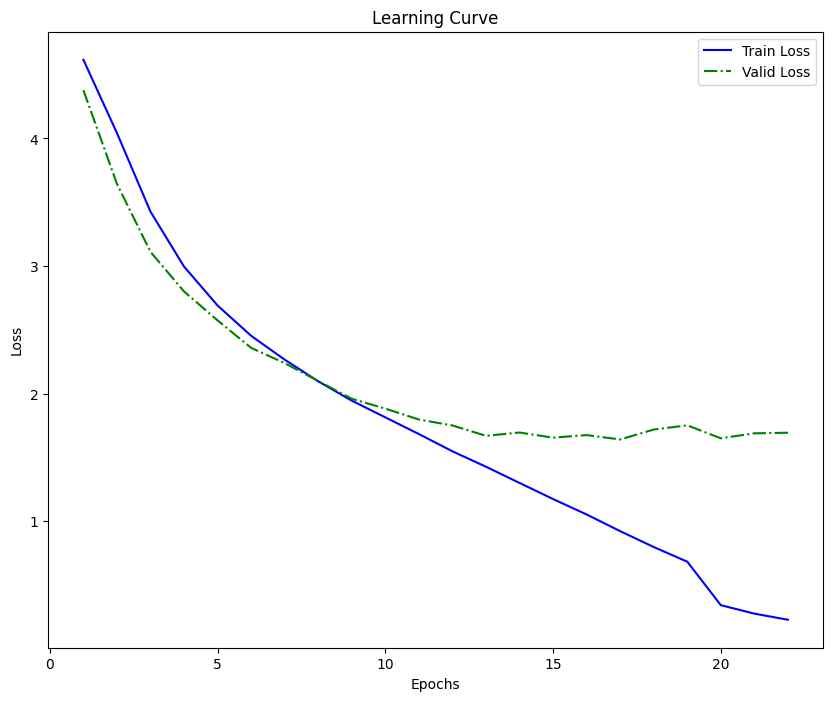

In [12]:
def main():
    """The main function for the Resnet-50."""
    print("Hello, Residual Network - 50")
    print("\n ------- \n")

    # Initialising the Data Handler
    data_handle = DataHandler(root_dir=dataset_path)

    # Loading the sets from disk
    train_set = data_handle.load_set("train")
    valid_set = data_handle.load_set("valid")

    # Initial sample sizes
    print("Initial Sample Sizes:")
    train_count = Counter(train_set.targets)
    valid_count = Counter(valid_set.targets)
    print(f"Train Set:\n{train_count}")
    print(f"\nValid Set:\n{valid_count}")
    print("\n ------- \n")

    # Moving Samples
    train_set_pre_prep, valid_set_pre_prep = data_handle.move_samples_from_train(train_set, move_percent=0.15)
    
    print("Moved Sample Sizes:")
    train_targets = [train_set.targets[i] for i in train_set_pre_prep.indices]
    valid_targets = [train_set.targets[i] for i in valid_set_pre_prep.indices]
    train_count = Counter(train_targets)
    valid_count = Counter(valid_targets)
    print(f"Train Set:\n{train_count}")
    print(f"\nValid Set:\n{valid_count}")
    print("\n ------- \n")

    # Preparing the sets
    train_prep = data_handle.prepare_dataset(train_set_pre_prep)
    valid_set_pre_prep = ConcatDataset([valid_set, valid_set_pre_prep])
    valid_prep = data_handle.prepare_dataset(valid_set_pre_prep)

    # Loading the Model
    model_base = Resnet34().to(device=DEVICE)
    resnet_34 = torch.nn.DataParallel(model_base)
    
    # Loading the Training Loop Handler
    optimizer = TrainingLoop(learning_rate=5e-4, model=resnet_34)
    
    # Training the model
    train_losses, valid_losses = optimizer.train_model(80, train_prep, valid_prep)

    # Plotting the losses
    plt.figure(figsize=(10, 8))
    plt.title("Learning Curve")
    plt.plot(range(1, len(train_losses) + 1), train_losses, c="b", ls="-", label="Train Loss")
    plt.plot(range(1, len(valid_losses) + 1), valid_losses, c="g", ls="-.", label="Valid Loss")
    plt.legend(loc="upper right")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")

    # Storing the Learning Curve
    if not ASSET_PATH.exists():
        ASSET_PATH.mkdir()
    plt.savefig(ASSET_PATH / "learning_curve.png")

    # Rendering the plot
    plt.show()


# ==== Driver Code ====
main()